## Qubit-Constrained Transpilation

Before proceeding with computation we want to *achieve the best mapping*  between our circuit and the device's physical layout in terms of qubit arrangement connectivity, this layout is referred to as the device's ''topology''.


In quantum computations we can represent **qubits as nodes** of a graph, with their **interconnections** being depicted **as edges**. The **coupling map** effectively serves as the adjacency matrix, delineating the connections between nodes (qubits) within the graph. The matrix consists of elements a_ij. The adjacency matrix elements are assigned with 2 values: a_ij=0 if the nodes/qubits I and j are not connected and a_ij=1 otherwise).

## 1. Purpose and Relevance

Depending on the circuit and device structure, situations can arise where certain gate operations are difficult to directly apply to target qubits.  In such cases, additional qubits are used in the calculation, referred to as "Ancilla" qubits. Adding Ancilla qubits can allow for the application of operations on otherwise unreachable qubits, but their addition comes at the cost of increased execution time. For large and complicated circuits, adding ancilla qubits can often increase runtime significantly.


Qubit-Constrained Transpilation is a tool to help overcome these limitations by taking into account the **device’s coupling map**. It takes the device's coupling map into account in order to determine the optimal selection of the most important qubits.


This challenge has prompted the emergence of a problem related to Qubit-Constrained Transpilation, taking into consideration the **device's coupling map**. To illustrate, consider a simplified example of a device alongside its coupling map. From this context, we aim to devise a method for selecting qubits that are topologically significant.




To decrease transpilation and simulation time the Rivet transpiler function `transpile_and_compress` selects topologically most important qubits of a backend device and produces a limited coupling map to decrease transpilation and simulation time:

![image.png](Fig1_compression_topology.png) 

*Fig.1. Node centralities for 27-qubit IBMQ backend topology.*


## 2. Theory behind Qubit-Constrained Transpilation

We use the flexible measure of node importance - node **closeness centrality** (the sum of the shortest paths between the node and all other nodes in the graph)  in the backend topology graph.  Here we calculate a centrality for a given backend, and transpile circuit and transpile them optimally using that input data.
Once importances are calculated - we traverse the topology graph using A-star search - starting from the most important node. Traversed nodes are added to a limited qubit list - which forms a connected subgraph. This discovered subgraph is used to limit backend topology (ancilla qubits and operations used) during transpilation which leads to less computation time.


Flexible measure of node importance can be expanded with other metrics - for example, neighbors counts or qubit noise levels.


## 3. Installation and imports


To run the code below make sure you have followed and installed Rivet transpiler. Check the installation steps from   **Readme.md**.

#### 3.1. Import Qiskit and Rivet transpiler functions required to run the examples below

In [1]:
import qiskit
from qiskit.visualization import plot_gate_map

from matplotlib import pyplot as plt

plt.style.use("dark_background")

%cd ../..

###Import Rivet transpiler functions
from rivet_transpiler import transpile
from rivet_transpiler import get_litmus_circuit
from rivet_transpiler import transpile_and_compress

/Users/haiqu/Desktop/Test2Qiskit1/qml-transpiler


For Qubit-Constrained Transpilation and closeness centrality caclulations we will use `rustworkx` library functions:

In [2]:
from rustworkx import spring_layout
from rustworkx import closeness_centrality
from rustworkx.visualization import mpl_draw

#### 3.2. Import Backend

Available backends from IBM Qiskit are listed at [4]. Some backend examples:
- the simplest 5qubit backend (for a simple test start from this one): `FakeBackend5QV2`
- 5qubit backend with noise:  `FakeLimaV2`
- 32-qubit backend: `FakeMontrealV2` 

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2
backend = FakeMontrealV2() 
qiskit.visualization.plot_gate_map(backend)

#### 3.3. Set up `litmus_circuit`
A quantum circuit designed for testing, diagnostic purposes.

In [4]:
QUBITS_COUNT = 3 #define number of qubits
litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")
litmus_circuit.draw(fold=-1) 

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

## 4. Experiments, results
Here we consider the case of 3-qubit circuit defined on 32-qubit backend `FakeMontrealV2`.

#### 4.1. Basic transpilation and transpilation with compression
Below that is possible to compare 2 circuits with basic transpilation and after `transpile_and_compress` usage. For the first case the ancilla qubits are added to run circuit for a given device topology, while in the second case taking into account the qubit centrality we transpile circuit to use properly a device topology without ancilla qubits involved, in such a way decreasing the computation time.


In [6]:
compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=backend,
    optimization_level=3,
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

┌──────────────┐┌───┐                            ░    
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                 └──────────────┘└─┬─┘                 │          ░    
                 ┌──────────────┐  │       ┌───┐       │  ┌───┐ Litmus 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼────■──┤ X ├──■────┼──┤ X ├───░────
                 ├──────────────┤  │  ┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘   ░    
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                 └──────────────┘     └───┘     └───┘└───┘        ░

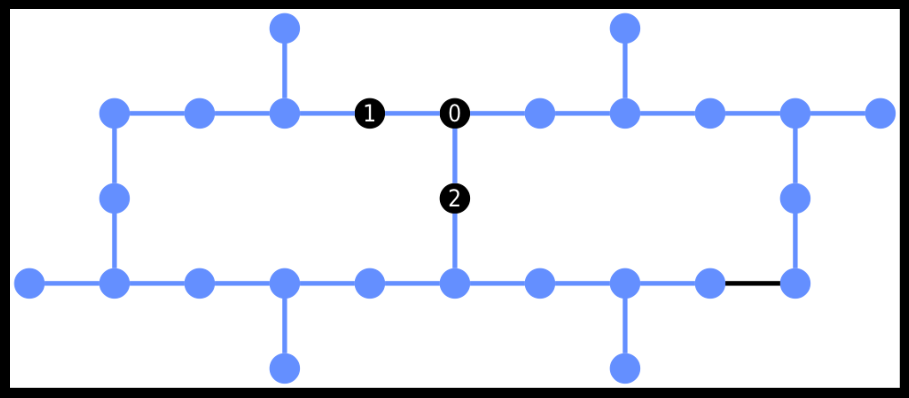

In [7]:
qiskit.visualization.plot_circuit_layout(compressed_litmus_circuit, backend)

#### 4.2. Custom Coupling Map

We are not limmited by beckend device architecture.  We retrieve the coupling map from the configuration of a backend and remove the edge between qubits 12 and 13 from the coupling list.


In [12]:
# Custom Coupling List

coupling_map = backend.coupling_map
coupling_list = [list(pair) for pair in coupling_map]

# Remove edge between qubits 12 and 13:
coupling_list.remove([12, 13])
coupling_list.remove([13, 12])
coupling_map = qiskit.transpiler.CouplingMap(couplinglist=coupling_list)

#coupling_map.draw()

In [ ]:
# Backend None

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)


compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=None,
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

<pre style="word-wrap: normal;white-space: pre;background: #fff0;line-height: 1.1;font-family: &quot;Courier New&quot;,Courier,monospace">            ┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░    </pre>

#### 4.3. Plot Backend Importances

In [10]:
def get_backend_importances_figure(backend, layout_seed=3):
    
    coupling_list = backend.coupling_map

    coupling_map = qiskit.transpiler.CouplingMap(couplinglist=coupling_list)
    
    graph = coupling_map.graph.to_undirected()
    
    positions = spring_layout(graph, seed=layout_seed)

    centralities = closeness_centrality(graph)

    importances = list(centralities.values())

    mpl_draw(graph,
             cmap="plasma",
             pos=positions,
             with_labels=True,
             node_color=importances)

    normalizer = plt.Normalize(vmin=min(importances), 
                               vmax=max(importances))

    scalar_mappable = plt.cm.ScalarMappable(cmap="plasma", norm=normalizer)
    
    colorbar = plt.colorbar(mappable=scalar_mappable, 
                            ax=plt.gca(), 
                            aspect=40)

    colorbar.ax.get_yaxis().labelpad = 15
    colorbar.ax.set_ylabel('Centrality', rotation=270)
    
    figure = plt.gcf()
    
    figure.patch.set_facecolor('white')
    figure.patch.set_alpha(0.05)
    
    plt.close()

    return figure

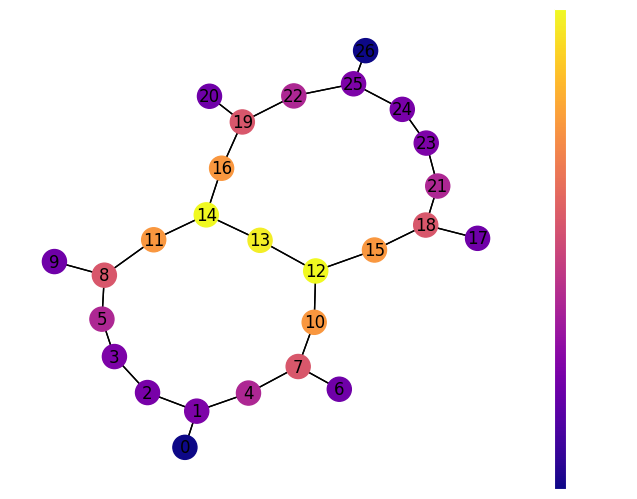

In [11]:
get_backend_importances_figure(backend)

## References

[1] https://qiskit.org/ecosystem/rustworkx/dev/apiref/rustworkx.closeness_centrality.html

[2] https://github.com/Qiskit/qiskit/blob/stable/0.14/qiskit/transpiler/coupling.py  

[3] https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.transpiler.CouplingMap

[4] Qiskit fake backends https://docs.quantum.ibm.com/api/qiskit/0.37/providers_fake_provider